# 1.NSCLC Sex-stratified SC Analysis

## Data selection, pseudobulk, create input for DESEQ2

alternating between enviroment scanpy for visualization and nsclc_gender_atlas for sccoda because in this last env sccoda.viz and sccoda.dat do not work anymore 

In [11]:
import scanpy as sc

In [12]:
import warnings
import numpy as np
import pandas as pd 
import scanpy as sc
#import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
#import altair as alt
#import pertpy as pt
#from pandas.api.types import is_categorical_dtype
#from pandas import CategoricalDtype

In [3]:
# Setup
import importlib
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt

#from sccoda.util import comp_ana as mod
#from sccoda.util import cell_composition_data as dat
#from sccoda.util import data_visualization as viz

import sccoda.datasets as scd

In [3]:

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from statannotations.Annotator import Annotator

In [ ]:
path = "/data/projects/2023/LCBiome/nsclc_gender_atlas_tmp"
input_path    = f"{path}/data/local.h5ad"

In [ ]:
adata = sc.read_h5ad(input_path) 

In [ ]:
nsclc_chrom = pd.read_csv(f"{path}/out/007_re_analysis/tables/input/adata_var_nsclc_chrom.csv")

In [ ]:
adata

In [ ]:
adata.obs.disease.value_counts()

In [ ]:
adata.obs.tumor_stage.value_counts()

In [ ]:
adata.obs.sex.value_counts()

In [ ]:
adata.obs.origin.value_counts()

### 01.SELECT ONLY male, female & tumor, normal_adjacent

In [ ]:
adata = adata[(adata.obs["disease"] != "normal") & (adata.obs["disease"] != "chronic obstructive pulmonary disease")] #exclude normal and COPD samples
adata = adata[adata.obs["tumor_stage"].notna()] #exclude samples without tumor stage
adata = adata[(adata.obs["sex"]=="male")| (adata.obs["sex"]=="female")]

In [ ]:
adata = adata[(adata.obs["origin"]=="tumor_primary")| (adata.obs["origin"]=="normal_adjacent")]

In [ ]:
adata.obs.disease.value_counts()

In [ ]:
adata.obs.tumor_stage.value_counts()

In [ ]:
adata.obs.sex.value_counts()

In [ ]:
adata.obs.origin.value_counts()

### 02.CELL TPYE RE-CLASIFICATION 

In [ ]:
adata.obs.cell_type.value_counts()

In [ ]:
adata.obs.cell_type_major.value_counts()

In [ ]:
cells_of_interest=['alveolar macrophage', 'neutrophil',
 'macrophage','malignant cell',
 'B cell',
  'regulatory T cell',
'CD4-positive, alpha-beta T cell',
 'CD8-positive, alpha-beta T cell',
 'neutrophils','epithelial cell of lung','multi-ciliated epithelial cell' ]
subset_adata = adata[adata.obs["cell_type"].isin(cells_of_interest)] 


In [ ]:
set(subset_adata.obs.cell_type)

In [ ]:
set(subset_adata.obs.cell_type_major)

In [ ]:
subset_adata.obs["cell_type"]= subset_adata.obs["cell_type"].replace(['epithelial cell of lung','multi-ciliated epithelial cell',], 'epithelial cell')
subset_adata.obs["cell_type"]= subset_adata.obs["cell_type"].replace(['alveolar macrophage'], 'macrophage')
subset_adata.obs["cell_type"]= subset_adata.obs["cell_type"].replace(['CD4-positive, alpha-beta T cell'], 'CD4+ T cell')
subset_adata.obs["cell_type"]= subset_adata.obs["cell_type"].replace(['CD8-positive, alpha-beta T cell'], 'CD8+ T cell')

In [ ]:
set(subset_adata.obs.cell_type)

In [ ]:
subset_adata

In [ ]:
subset_adata.obs.disease.value_counts()

In [ ]:
adata

## PAIRED SAMPLES REMOVE NSCLC 

In [ ]:
subset_adata = subset_adata[(subset_adata.obs["disease"]!="non-small cell lung carcinoma")]

In [ ]:
subset_adata = subset_adata[(subset_adata.obs["disease"]!="squamous cell lung carcinoma")]

In [ ]:
df_grouped = subset_adata.obs.groupby(["origin","donor_id"]).count()

In [ ]:
df_grouped.reset_index(inplace= True)

In [ ]:
df_grouped_normal = df_grouped[df_grouped["origin"]=="normal_adjacent"]

In [ ]:
df_grouped_normal = df_grouped_normal[df_grouped_normal['sample'] != 0]

In [ ]:
df_grouped_tumor = df_grouped[df_grouped["origin"]=="tumor_primary"]

In [ ]:
df_grouped_tumor = df_grouped_tumor[df_grouped_tumor['sample'] != 0]

In [ ]:
list(set(df_grouped_tumor.donor_id))

In [ ]:
common_ids =list(set(df_grouped_normal.donor_id)& set(df_grouped_tumor.donor_id))

In [ ]:
len(common_ids)

In [ ]:
paired_adata = subset_adata[subset_adata.obs['donor_id'].isin(common_ids)].copy()

In [ ]:
df = paired_adata.obs#
origin_counts = df.groupby('origin')['donor_id'].nunique().reset_index()
origin_counts.columns = ['origin', 'count']

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=origin_counts, x='origin', y='count', palette='viridis')
plt.xlabel('Origin')
plt.ylabel('Number of Unique Donor IDs')
plt.title('Number of Unique Donor IDs per Origin')
plt.show()

In [ ]:
df = paired_adata.obs#
origin_counts = df.groupby('disease')['donor_id'].nunique().reset_index()
origin_counts.columns = ['disease', 'count']

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=origin_counts, x='disease', y='count', palette='viridis')
plt.xlabel('disease')
plt.ylabel('Number of Unique Donor IDs')
plt.title('Number of Unique Donor IDs per disease')
plt.show()

In [ ]:
#paired_adata.write_h5ad("paired_adata.h5ad")

In [5]:
paired_adata = sc.read_h5ad("paired_adata.h5ad")

In [12]:
paired_adata_normal = paired_adata[paired_adata.obs["origin"]=="normal_adjacent"]
paired_adata_tumor = paired_adata[paired_adata.obs["origin"]=="tumor_primary"]

In [7]:
df_num = paired_adata.obs[["cell_type","sex"]].value_counts()

In [13]:
df_num_normal = paired_adata_normal.obs[["cell_type","sex"]].value_counts()

In [14]:
df_num_tumor = paired_adata_tumor.obs[["cell_type","sex"]].value_counts()

In [8]:
df_num

cell_type          sex   
macrophage         female    59801
CD4+ T cell        female    54058
macrophage         male      44468
CD4+ T cell        male      38429
CD8+ T cell        female    36305
                   male      34086
epithelial cell    male      11285
                   female     9753
regulatory T cell  female     9498
B cell             female     9478
malignant cell     female     9223
                   male       7716
B cell             male       7375
regulatory T cell  male       6960
neutrophil         female     3744
                   male       2402
dtype: int64

In [15]:
df_num_normal

cell_type          sex   
macrophage         female    38266
CD4+ T cell        female    27339
macrophage         male      27187
CD4+ T cell        male      17750
CD8+ T cell        female    16346
                   male      14167
epithelial cell    male       2618
neutrophil         female     2616
epithelial cell    female     2339
regulatory T cell  female     1778
B cell             female     1706
neutrophil         male       1539
B cell             male       1182
regulatory T cell  male       1064
malignant cell     male        318
                   female      256
dtype: int64

In [16]:
df_num_tumor

cell_type          sex   
CD4+ T cell        female    26719
macrophage         female    21535
CD4+ T cell        male      20679
CD8+ T cell        female    19959
                   male      19919
macrophage         male      17281
malignant cell     female     8967
epithelial cell    male       8667
B cell             female     7772
regulatory T cell  female     7720
epithelial cell    female     7414
malignant cell     male       7398
B cell             male       6193
regulatory T cell  male       5896
neutrophil         female     1128
                   male        863
dtype: int64

In [124]:
df_num.to_csv("cell_count.csv")

In [28]:
df_num_tumor.to_csv("cell_count_tumor.csv")

In [29]:
df_num_normal.to_csv("cell_count_normal.csv")

In [ ]:
#data_all.write_h5ad("data_all.h5ad")

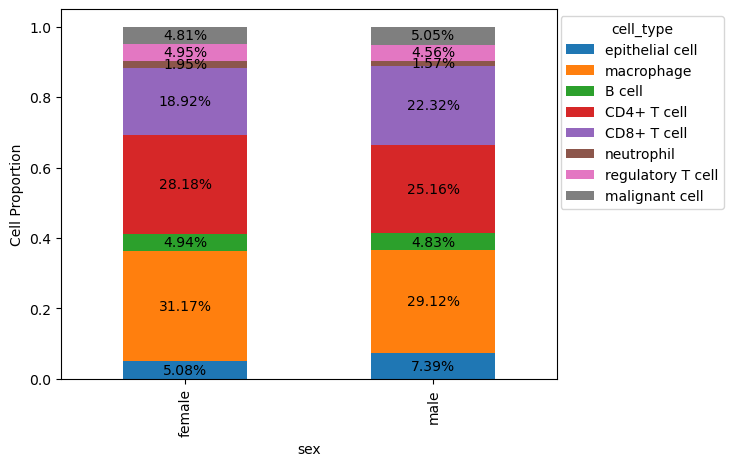

In [20]:
tmp = pd.crosstab(paired_adata.obs['cell_type'], paired_adata.obs['sex'], normalize='columns').T

# Plotting the stacked barplot
ax = tmp.plot(kind='bar', stacked=True)

# Annotating percentages
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.text(x + width / 2, y + height / 2, f'{height:.2%}', ha='center', va='center')

# Adjusting legend
ax.legend(title='cell_type', bbox_to_anchor=(1.35, 1), loc='upper right')
# Adding y-axis label
ax.set_ylabel('Cell Proportion')


#plt.tight_layout()

# Save the plot
plt.savefig('stacked_barplot_with_percentages.png', bbox_inches='tight')
# Show the plot
plt.show()

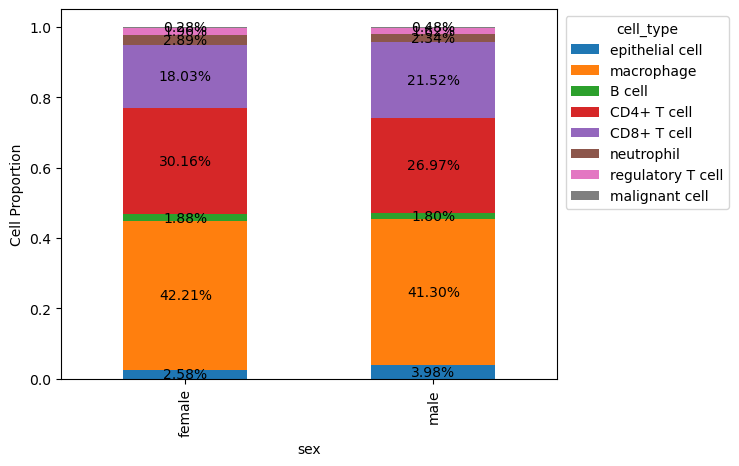

In [46]:
tmp = pd.crosstab(paired_adata_normal.obs['cell_type'], paired_adata_normal.obs['sex'], normalize='columns').T

# Plotting the stacked barplot
ax = tmp.plot(kind='bar', stacked=True)

# Annotating percentages
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.text(x + width / 2, y + height / 2, f'{height:.2%}', ha='center', va='center')

# Adjusting legend
ax.legend(title='cell_type', bbox_to_anchor=(1.36, 1), loc='upper right')
# Adding y-axis label
ax.set_ylabel('Cell Proportion')


#plt.tight_layout()

# Save the plot
#plt.savefig('stacked_barplot_with_percentages_normal.png', bbox_inches='tight')
# Show the plot
plt.show()

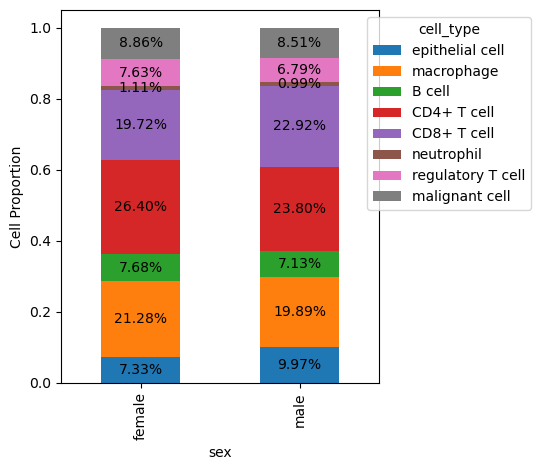

In [38]:
tmp = pd.crosstab(paired_adata_tumor.obs['cell_type'], paired_adata_tumor.obs['sex'], normalize='columns').T

# Plotting the stacked barplot
ax = tmp.plot(kind='bar', stacked=True)

# Annotating percentages
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.text(x + width / 2, y + height / 2, f'{height:.2%}', ha='center', va='center')

# Adjusting legend
ax.legend(title='cell_type', bbox_to_anchor=(1.5, 1), loc='upper right')
# Adding y-axis label
ax.set_ylabel('Cell Proportion')


plt.tight_layout()

# Save the plot
plt.savefig('stacked_barplot_with_percentages_tumor.png', bbox_inches='tight')
# Show the plot
plt.show()

In [59]:
val_counts = paired_adata.obs['cell_type'].value_counts()

In [60]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(figsize = (1,4))
ov.pl.cellproportion(adata=adata,celltype_clusters='clusters',
                    groupby='age(days)',legend=True,ax=ax)

macrophage           104269
CD4+ T cell           92487
CD8+ T cell           70391
epithelial cell       21038
malignant cell        16939
B cell                16853
regulatory T cell     16458
neutrophil             6146
Name: cell_type, dtype: int64

## SUMMARY 
- Filtered for male, female & tumor, normal_adjacent
- Filtered and reclassified cells of interest: 'B cell','CD4+ T cell', 'CD8+ T cell', 'epithelial cell', 'macrophage', 'malignant cell', 'neutrophil', 'regulatory Tcell'
- Filtered to exclude samples coming from NSCLC
- Filtered for PAIRED SAMPLES (82 donor_id that have normal_adjacent and tumor_primary  samples)
- KEEP LUADN AND LUSC

In [47]:
frac_by_condition = (
    paired_adata_normal.obs.groupby(["dataset", "cell_type", "tumor_stage", "donor_id","origin"])
    .apply(lambda x: x.value_counts("sex", normalize=False))
    .reset_index(name="n_cells")
    .assign(condition=lambda x: x["cell_type"].astype(str))
)

In [48]:
frac_by_condition

,dataset,cell_type,tumor_stage,donor_id,origin,sex,n_cells,condition
0,Goveia_Carmeliet_2020,epithelial cell,early,Goveia_Carmeliet_2020_patient_45,normal_adjacent,female,21,epithelial cell
1,Goveia_Carmeliet_2020,epithelial cell,early,Goveia_Carmeliet_2020_patient_45,normal_adjacent,male,0,epithelial cell
2,Goveia_Carmeliet_2020,epithelial cell,early,Goveia_Carmeliet_2020_patient_46,normal_adjacent,female,11,epithelial cell
3,Goveia_Carmeliet_2020,epithelial cell,early,Goveia_Carmeliet_2020_patient_46,normal_adjacent,male,0,epithelial cell
4,Goveia_Carmeliet_2020,epithelial cell,early,Goveia_Carmeliet_2020_patient_50,normal_adjacent,female,10,epithelial cell
...,...,...,...,...,...,...,...,...
807,UKIM-V-2,malignant cell,early,UKIM-V-2_P13,normal_adjacent,male,0,malignant cell
808,UKIM-V-2,malignant cell,early,UKIM-V-2_P14,normal_adjacent,female,4,malignant cell
809,UKIM-V-2,malignant cell,early,UKIM-V-2_P14,normal_adjacent,male,0,malignant cell
810,UKIM-V-2,malignant cell,early,UKIM-V-2_P16,normal_adjacent,female,3,malignant cell


In [49]:
frac_pivot = (
    frac_by_condition.pivot(
        index=["donor_id", "dataset", "sex", "tumor_stage","origin"],
        columns="cell_type",
        values="n_cells",
    )
    .reset_index()
    #.drop(columns="other")
)


In [50]:
frac_pivot

cell_type,donor_id,dataset,sex,tumor_stage,origin,epithelial cell,macrophage,B cell,CD4+ T cell,CD8+ T cell,neutrophil,regulatory T cell,malignant cell
0,Goveia_Carmeliet_2020_patient_45,Goveia_Carmeliet_2020,female,early,normal_adjacent,21.0,714.0,NaN,4.0,3.0,NaN,NaN,2.0
1,Goveia_Carmeliet_2020_patient_45,Goveia_Carmeliet_2020,male,early,normal_adjacent,0.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0
2,Goveia_Carmeliet_2020_patient_46,Goveia_Carmeliet_2020,female,early,normal_adjacent,11.0,2129.0,NaN,NaN,NaN,NaN,NaN,3.0
3,Goveia_Carmeliet_2020_patient_46,Goveia_Carmeliet_2020,male,early,normal_adjacent,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0
4,Goveia_Carmeliet_2020_patient_50,Goveia_Carmeliet_2020,female,early,normal_adjacent,10.0,990.0,NaN,12.0,39.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,UKIM-V-2_P16,UKIM-V-2,male,early,normal_adjacent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
114,UKIM-V_P1,UKIM-V,female,early,normal_adjacent,25.0,18.0,16.0,304.0,471.0,216.0,34.0,6.0
115,UKIM-V_P1,UKIM-V,male,early,normal_adjacent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
116,UKIM-V_P3,UKIM-V,female,early,normal_adjacent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data_all = dat.from_pandas(
    frac_pivot, covariate_columns=["donor_id", "dataset", "sex", "tumor_stage","origin"]
)

In [ ]:
data_all.obs["sex"] = pd.Categorical(
    data_all.obs["sex"], categories=["male", "female"]
)

In [ ]:
data_all._sanitize()

In [ ]:
data_all

In [ ]:
#data_all.write_h5ad("data_all.h5ad")

In [6]:
data_all = sc.read_h5ad("data_all.h5ad")

In [8]:
data_all.obs

,donor_id,dataset,sex,tumor_stage,origin
0,Goveia_Carmeliet_2020_patient_45,Goveia_Carmeliet_2020,female,early,normal_adjacent
1,Goveia_Carmeliet_2020_patient_45,Goveia_Carmeliet_2020,female,early,tumor_primary
2,Goveia_Carmeliet_2020_patient_45,Goveia_Carmeliet_2020,male,early,normal_adjacent
3,Goveia_Carmeliet_2020_patient_45,Goveia_Carmeliet_2020,male,early,tumor_primary
4,Goveia_Carmeliet_2020_patient_46,Goveia_Carmeliet_2020,female,early,normal_adjacent
...,...,...,...,...,...
231,UKIM-V_P1,UKIM-V,male,early,tumor_primary
232,UKIM-V_P3,UKIM-V,female,early,normal_adjacent
233,UKIM-V_P3,UKIM-V,female,early,tumor_primary
234,UKIM-V_P3,UKIM-V,male,early,normal_adjacent


In [9]:
data_all_tumor = data_all[data_all.obs["origin"]=="tumor_primary"]
data_all_normal = data_all[data_all.obs["origin"]=="normal_adjacent"]

/tmp/ipykernel_226175/1574092851.py:64: RuntimeWarning: invalid value encountered in divide
  X = data.X/sample_sums


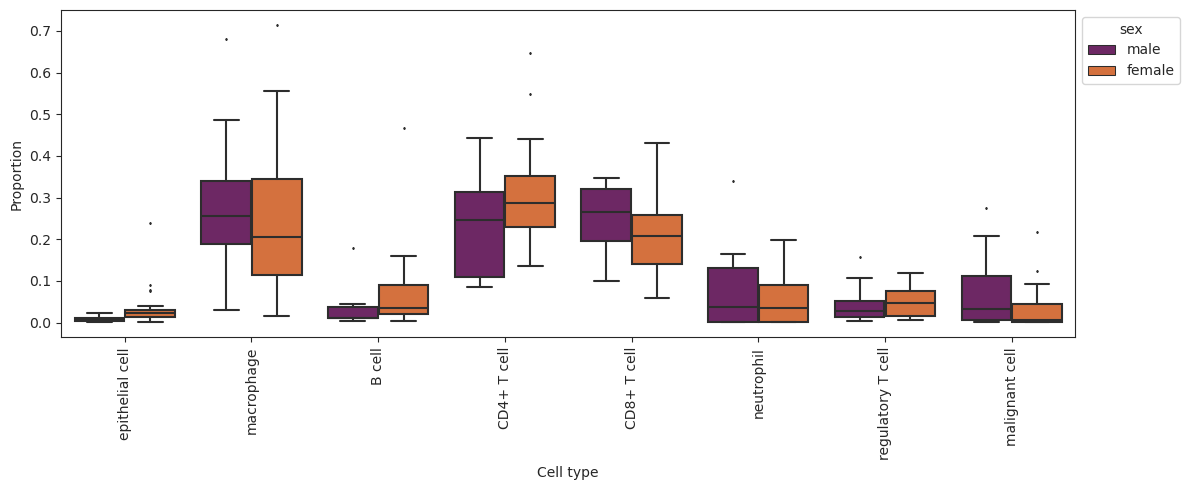

In [36]:
boxplots(data_all, feature_name="sex", figsize=(12, 5), cmap = "inferno")

plt.savefig( "cell_proportion_nosig.png")


In [144]:
boxplots(data_all_normal, feature_name="sex", figsize=(12, 5), cmap = "inferno")

#plt.savefig( "cell_proportion_nosig.png")


/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/anndata/_core/views.py:144: RuntimeWarning: invalid value encountered in divide
  results = super().__array_ufunc__(


In [99]:
boxplots(data_all_normal, feature_name="sex", figsize=(12, 5), cmap = "inferno")

#plt.savefig( "cell_proportion_nosig_normal.png")


/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/anndata/_core/views.py:144: RuntimeWarning: invalid value encountered in divide
  results = super().__array_ufunc__(


<Axes: xlabel='Cell type', ylabel='Proportion'>

/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/anndata/_core/views.py:144: RuntimeWarning: invalid value encountered in divide
  results = super().__array_ufunc__(


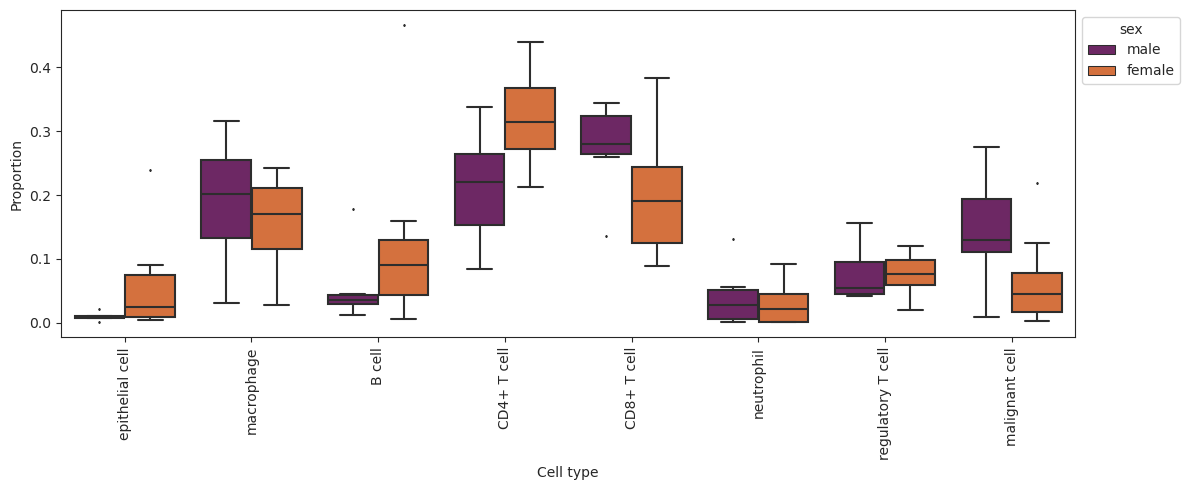

<Axes: xlabel='Cell type', ylabel='Proportion'>

In [150]:
boxplots(data_all_tumor, feature_name="sex", figsize=(12, 5), cmap = "inferno")

#
#plt.savefig( "cell_proportion_nosig_tumor.png")


/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/anndata/_core/views.py:144: RuntimeWarning: invalid value encountered in divide
  results = super().__array_ufunc__(


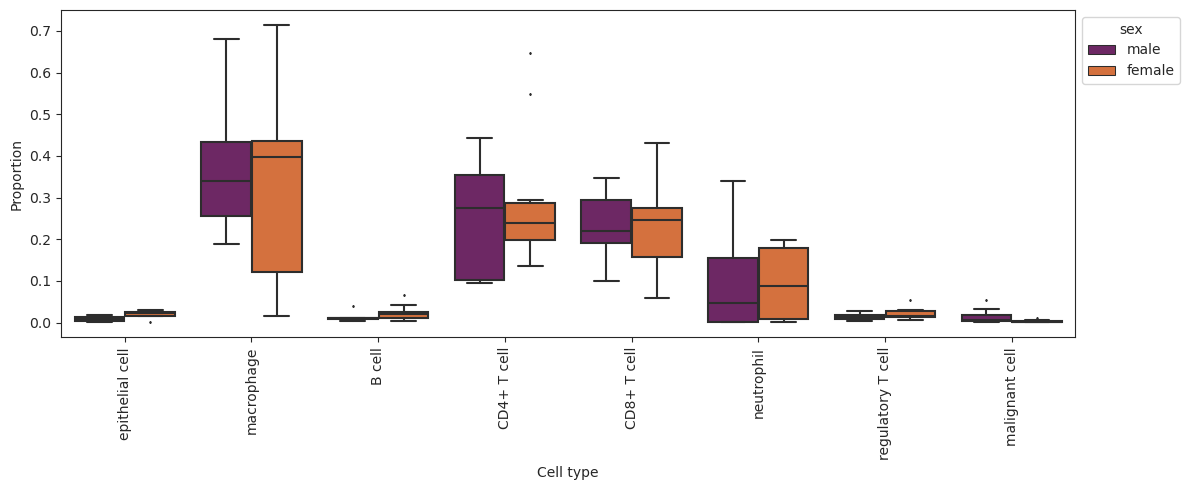

<Axes: xlabel='Cell type', ylabel='Proportion'>

In [151]:
boxplots(data_all_normal, feature_name="sex", figsize=(12, 5), cmap = "inferno")

#
#plt.savefig( "cell_proportion_nosig_tumor.png")


In [ ]:
pd.DataFrame.iteritems = pd.DataFrame.items

In [14]:
import anndata as ad

/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/anndata/_core/views.py:144: RuntimeWarning: invalid value encountered in divide
  results = super().__array_ufunc__(
/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/seaborn/categorical.py:1296: UserWarning: 5.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<Figure size 640x480 with 0 Axes>

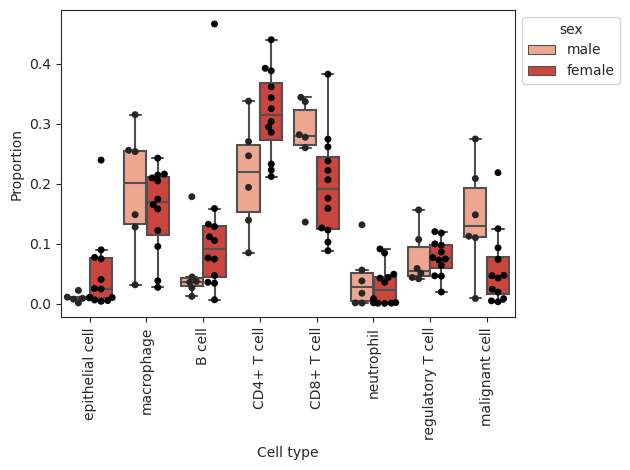

In [168]:
boxplots(
    data_all_tumor,
    feature_name="sex",
    plot_facets=False,
   # y_scale="log",
    add_dots=True,
    cmap="Reds",
)
plt.savefig( "small_cell_prop_tumor.png")

/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/anndata/_core/views.py:144: RuntimeWarning: invalid value encountered in divide
  results = super().__array_ufunc__(
/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/seaborn/categorical.py:1296: UserWarning: 5.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/seaborn/categorical.py:1296: UserWarning: 6.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/seaborn/categorical.py:1296: UserWarning: 13.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<Figure size 640x480 with 0 Axes>

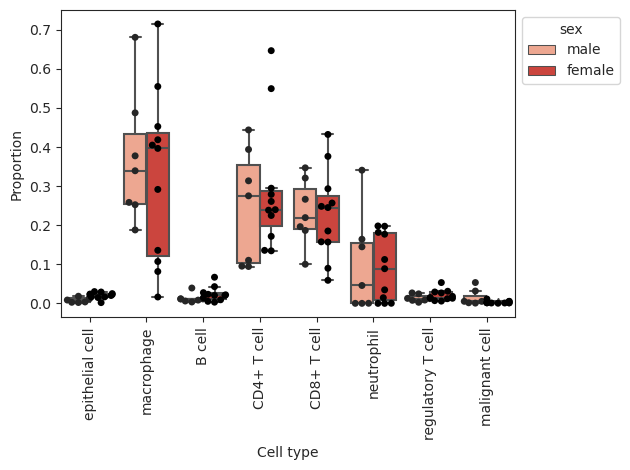

In [167]:
boxplots(
    data_all_normal,
    feature_name="sex",
    plot_facets=False,
   # y_scale="log",
    add_dots=True,
    cmap="Reds",
)
plt.savefig( "small_cell_prop_normal.png")

/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/anndata/_core/views.py:144: RuntimeWarning: invalid value encountered in divide
  results = super().__array_ufunc__(
/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/seaborn/axisgrid.py:703: FutureWarning: iterite

<Figure size 640x480 with 0 Axes>

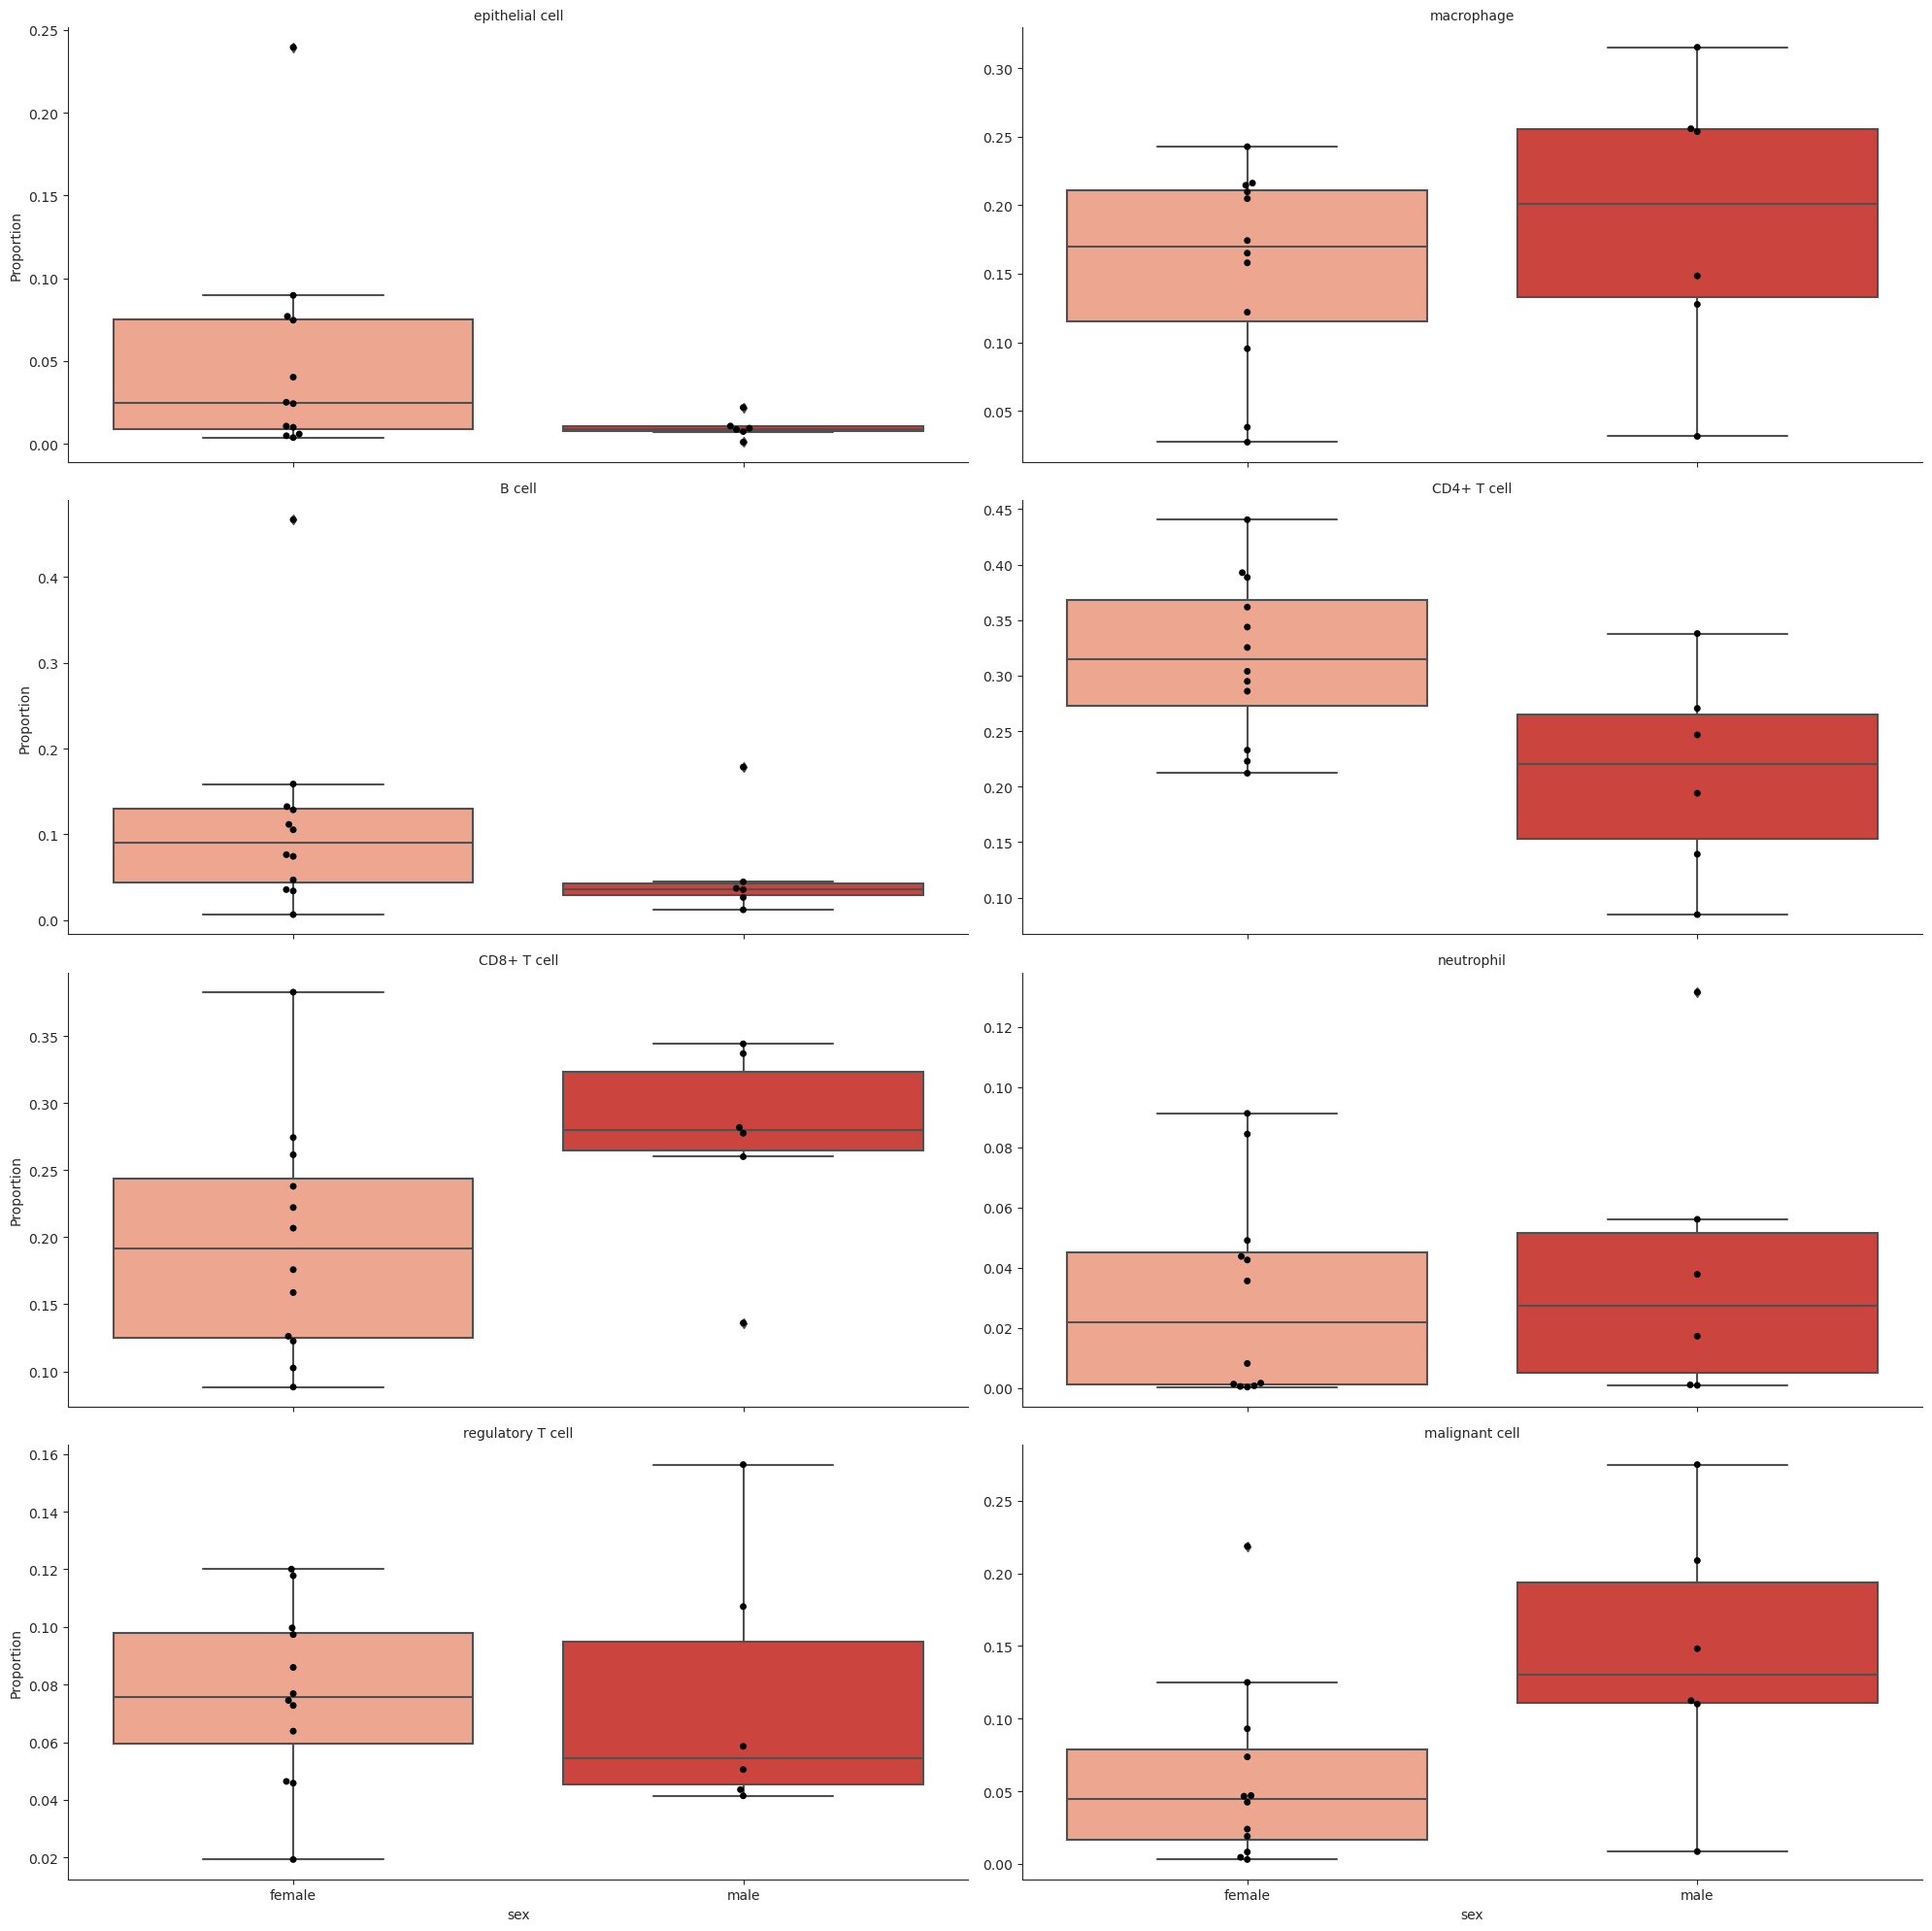

In [166]:
boxplots(
    data_all_normal,
    feature_name="sex",
    plot_facets=True,
   # y_scale="log",
    add_dots=True,
    cmap="Reds",
    save=True
)
plt.savefig("facet_cell_prop_normal.svg")

/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/kvalem/.conda/envs/scanpy/lib/python3.12/s

<Figure size 640x480 with 0 Axes>

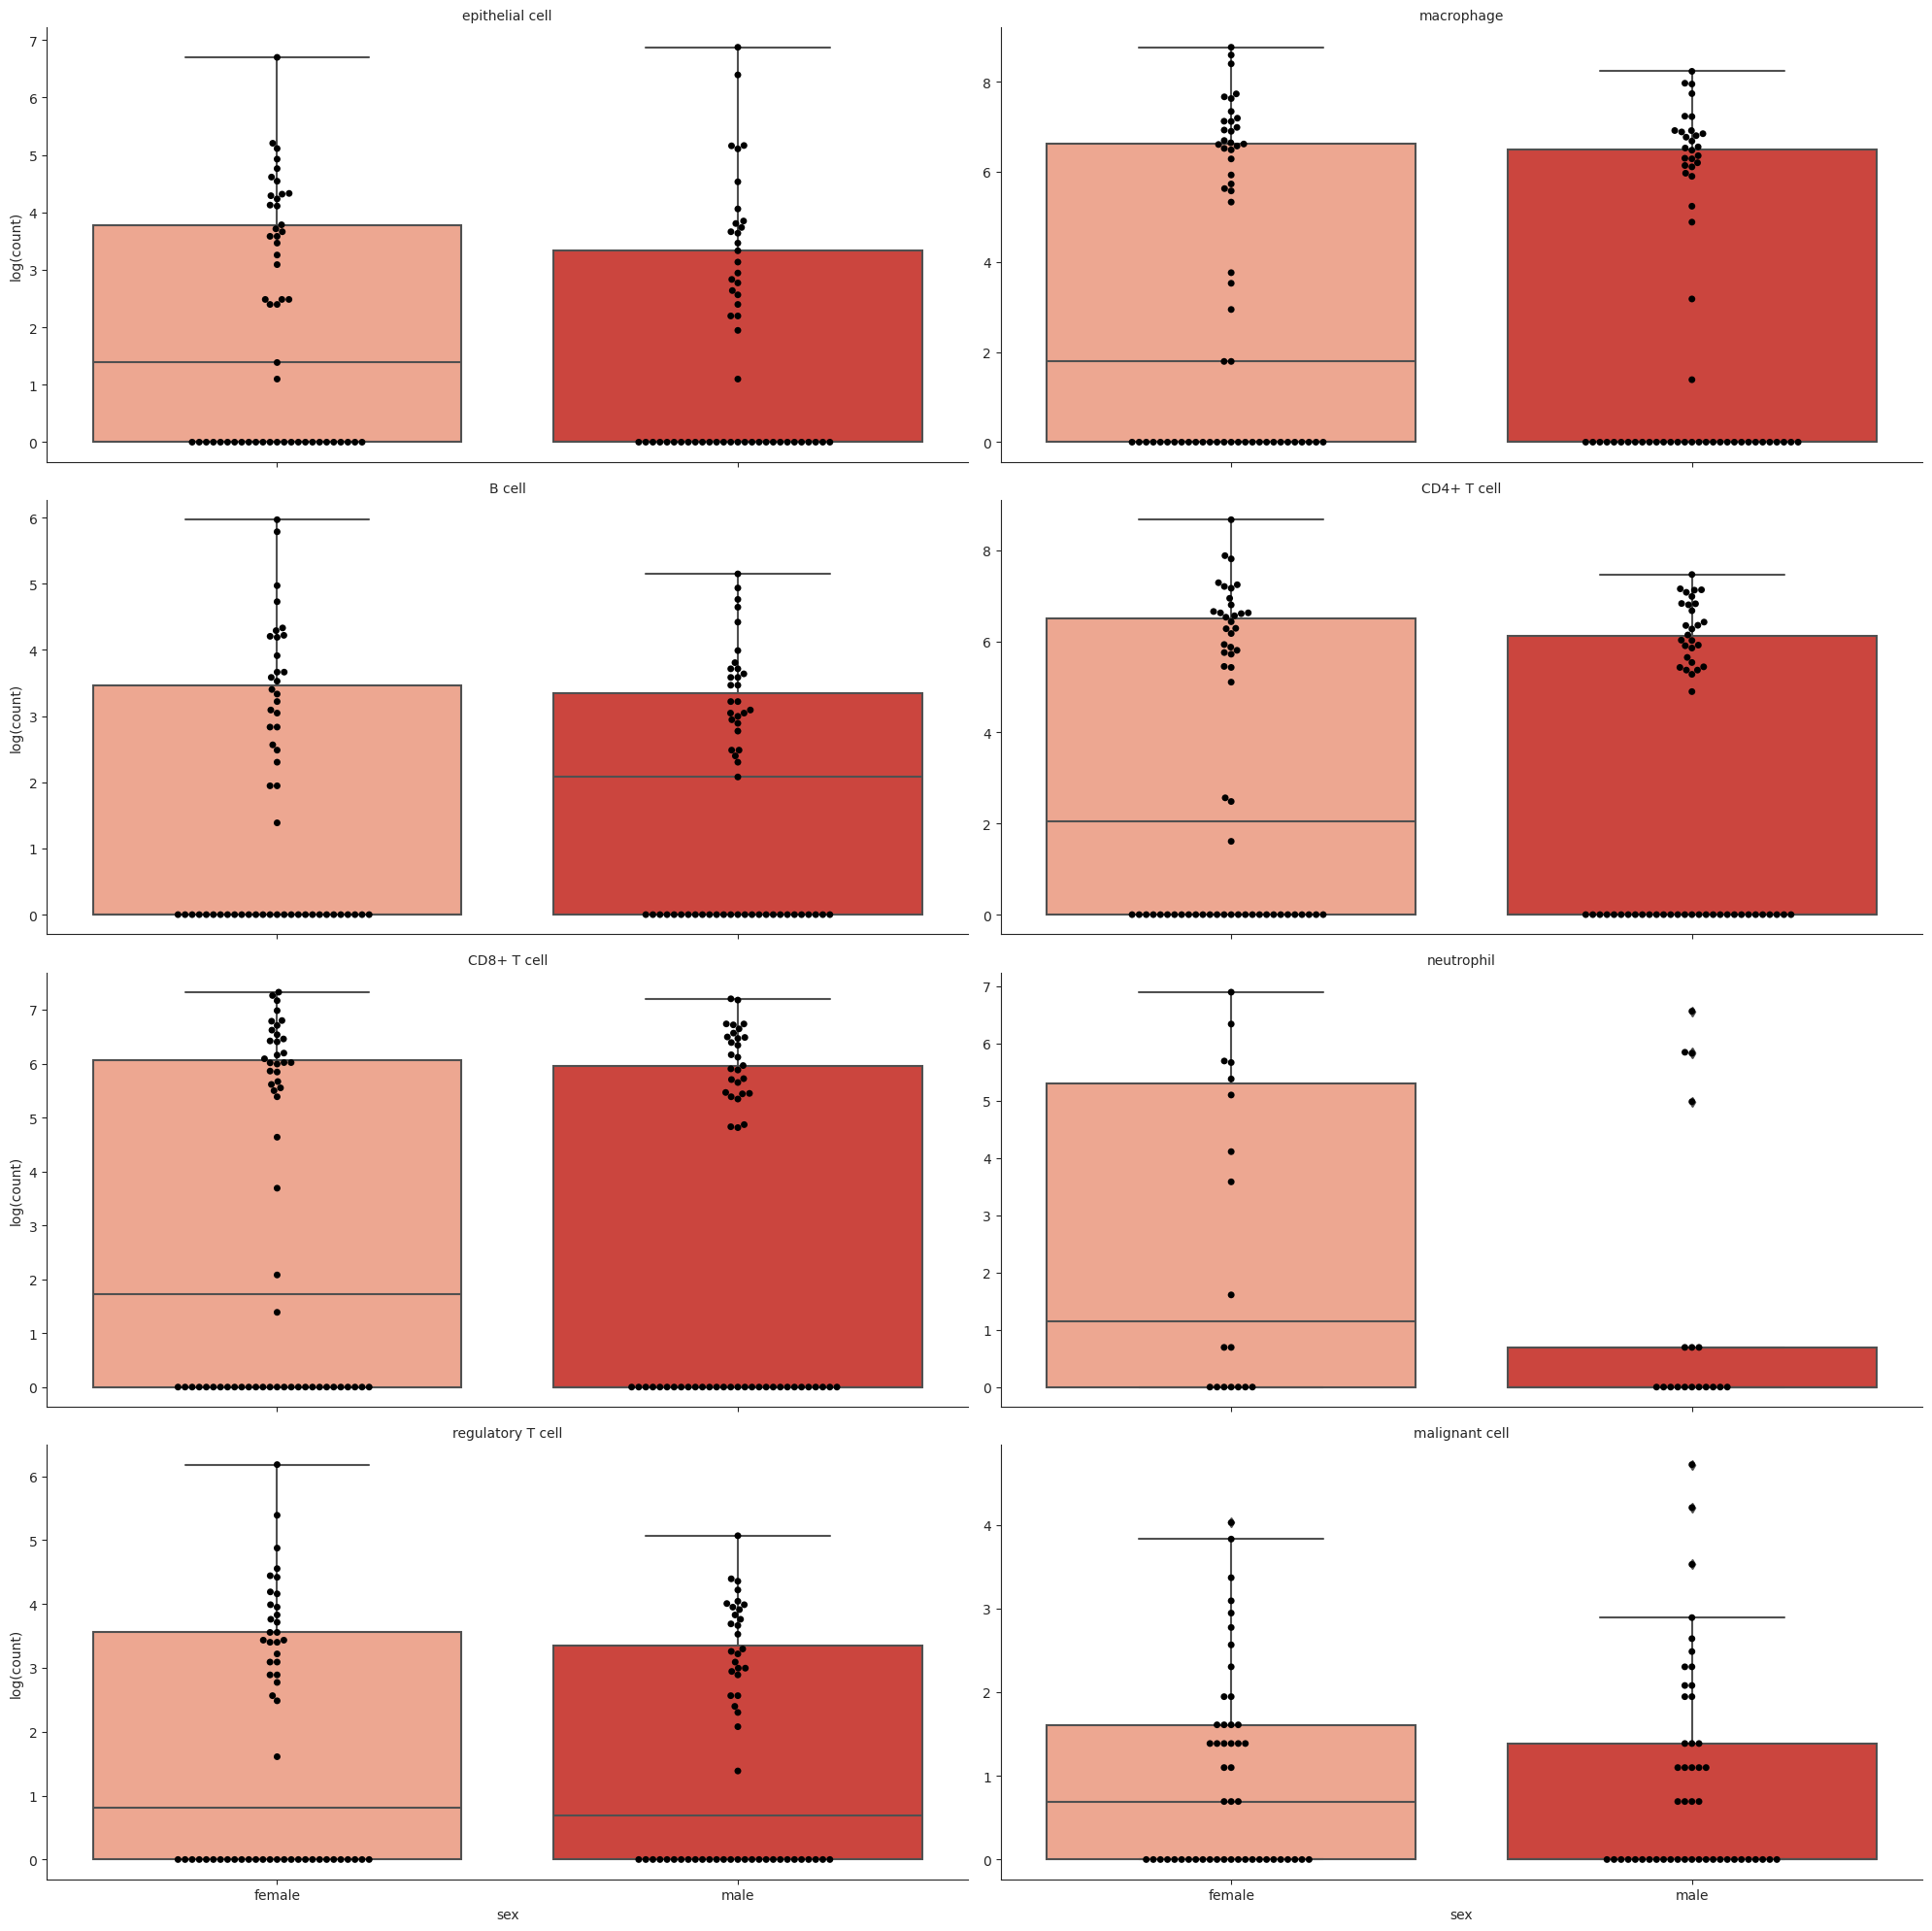

In [182]:
boxplots(
    data_all_normal,
    feature_name="sex",
    plot_facets=True,
   y_scale="log",
    add_dots=True,
    cmap="Reds",
)
plt.savefig("facet_cell_prop_tumor.png")

In [105]:
plot_df_tumor = plot_df_tumor.dropna()

In [106]:
import pandas as pd
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests


# Unique cell types
cell_types = plot_df_tumor['Cell type'].unique()

# Dictionary to hold t-test results
t_test_results = {}

# Perform t-test for each cell type
for cell_type in cell_types:
    # Subset the data by cell type
    cell_data = plot_df_tumor[plot_df_tumor['Cell type'] == cell_type]
    
    # Separate the data by sex
    male_data = cell_data[cell_data['sex'] == 'male']['Proportion']
    female_data = cell_data[cell_data['sex'] == 'female']['Proportion']
    
    # Perform t-test
    t_stat, p_value = ttest_ind(male_data, female_data)
    
    # Store the results
    t_test_results[cell_type] = {'t_stat': t_stat, 'p_value': p_value}

# Convert results to DataFrame for better display
t_test_results_df = pd.DataFrame(t_test_results).T

# Adjust p-values using Benjamini-Hochberg method
_, adjusted_p_values, _, _ = multipletests(t_test_results_df['p_value'], method='fdr_bh')

# Add adjusted p-values to the DataFrame
t_test_results_df['adjusted_p_value'] = adjusted_p_values

print(t_test_results_df)


                     t_stat   p_value  adjusted_p_value
epithelial cell   -1.457951  0.164203          0.328406
macrophage         0.795758  0.437820          0.583760
B cell            -1.121385  0.278673          0.445876
CD4+ T cell       -2.658385  0.017173          0.132598
CD8+ T cell        1.849705  0.082915          0.221106
neutrophil         0.554239  0.587079          0.670948
regulatory T cell -0.024765  0.980549          0.980549
malignant cell     2.331125  0.033149          0.132598


In [142]:
import pandas as pd
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# Unique cell types
cell_types = plot_df_tumor['Cell type'].unique()

# Dictionary to hold Wilcoxon test results
wilcoxon_test_results = {}

# Perform Wilcoxon test for each cell type
for cell_type in cell_types:
    # Subset the data by cell type
    cell_data = plot_df_tumor[plot_df_tumor['Cell type'] == cell_type]
    
    # Separate the data by sex
    male_data = cell_data[cell_data['sex'] == 'male']['Proportion']
    female_data = cell_data[cell_data['sex'] == 'female']['Proportion']
    
    # Perform Wilcoxon rank-sum test
    stat, p_value = mannwhitneyu(male_data, female_data, alternative='two-sided')
    
    # Store the results
    wilcoxon_test_results[cell_type] = {'stat': stat, 'p_value': p_value}

# Convert results to DataFrame for better display
wilcoxon_test_results_df = pd.DataFrame(wilcoxon_test_results).T

# Adjust p-values using Benjamini-Hochberg method
_, adjusted_p_values, _, _ = multipletests(wilcoxon_test_results_df['p_value'], method='fdr_bh')

# Add adjusted p-values to the DataFrame
wilcoxon_test_results_df['adjusted_p_value'] = adjusted_p_values

print(wilcoxon_test_results_df)


                     stat   p_value  adjusted_p_value
epithelial cell    1546.5  0.095967           0.18096
macrophage         1572.5  0.149572           0.18096
B cell             1548.5  0.099451           0.18096
CD4+ T cell        1540.5  0.086098           0.18096
CD8+ T cell        1584.5  0.180960           0.18096
neutrophil         1568.5  0.140090           0.18096
regulatory T cell  1557.5  0.116394           0.18096
malignant cell     1584.5  0.180960           0.18096


In [141]:
import pandas as pd
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# Unique cell types
cell_types = plot_df_normal['Cell type'].unique()

# Dictionary to hold Wilcoxon test results
wilcoxon_test_results = {}

# Perform Wilcoxon test for each cell type
for cell_type in cell_types:
    # Subset the data by cell type
    cell_data = plot_df_normal[plot_df_normal['Cell type'] == cell_type]
    
    # Separate the data by sex
    male_data = cell_data[cell_data['sex'] == 'male']['Proportion']
    female_data = cell_data[cell_data['sex'] == 'female']['Proportion']
    
    # Perform Wilcoxon rank-sum test
    stat, p_value = mannwhitneyu(male_data, female_data, alternative='two-sided')
    
    # Store the results
    wilcoxon_test_results[cell_type] = {'stat': stat, 'p_value': p_value}

# Convert results to DataFrame for better display
wilcoxon_test_results_df = pd.DataFrame(wilcoxon_test_results).T

# Adjust p-values using Benjamini-Hochberg method
_, adjusted_p_values, _, _ = multipletests(wilcoxon_test_results_df['p_value'], method='fdr_bh')

# Add adjusted p-values to the DataFrame
wilcoxon_test_results_df['adjusted_p_value'] = adjusted_p_values

print(wilcoxon_test_results_df)


                     stat   p_value  adjusted_p_value
epithelial cell    1594.0  0.209089          0.378249
macrophage         1625.0  0.322481          0.378249
B cell             1607.0  0.252528          0.378249
CD4+ T cell        1618.0  0.293904          0.378249
CD8+ T cell        1627.0  0.330968          0.378249
neutrophil         1621.0  0.305936          0.378249
regulatory T cell  1609.0  0.259732          0.378249
malignant cell     1640.0  0.389610          0.389610


In [ ]:
viz.boxplots(
    data_all,
    feature_name="sex",
    plot_facets=False,
   # y_scale="log",
    add_dots=True,
    cmap="Reds",
)

In [ ]:
ax = viz.boxplots(
    data_all,
    feature_name="sex",
    plot_facets=True,
   y_scale="log",
    #args_swarmplot= {hue:"dataset"},
    add_dots=True,
    cmap="Reds",
)



In [43]:
data_all.obs

,donor_id,dataset,sex,tumor_stage,origin
0,Goveia_Carmeliet_2020_patient_45,Goveia_Carmeliet_2020,female,early,normal_adjacent
1,Goveia_Carmeliet_2020_patient_45,Goveia_Carmeliet_2020,female,early,tumor_primary
2,Goveia_Carmeliet_2020_patient_45,Goveia_Carmeliet_2020,male,early,normal_adjacent
3,Goveia_Carmeliet_2020_patient_45,Goveia_Carmeliet_2020,male,early,tumor_primary
4,Goveia_Carmeliet_2020_patient_46,Goveia_Carmeliet_2020,female,early,normal_adjacent
...,...,...,...,...,...
231,UKIM-V_P1,UKIM-V,male,early,tumor_primary
232,UKIM-V_P3,UKIM-V,female,early,normal_adjacent
233,UKIM-V_P3,UKIM-V,female,early,tumor_primary
234,UKIM-V_P3,UKIM-V,male,early,normal_adjacent


In [ ]:
import numpy as np

In [ ]:
data = data_all
feature_name="sex"
y_scale = "relative"
plot_facets= True
add_dots= True
cell_types = None
args_boxplot= {}
args_swarmplot= {}
figsize= None
dpi= 100
cmap= "Blues"
plot_legend = True
level_order = None

In [ ]:
#plot_df.to_csv("plot_df.csv")

In [38]:
plot_df  = pd.read_csv("plot_df.csv", index_col=0)

In [ ]:
annot.configure()

In [141]:
count_df

,epithelial cell,macrophage,B cell,CD4+ T cell,CD8+ T cell,neutrophil,regulatory T cell,malignant cell,sex
0,3.091042,6.572283,NaN,1.609438,1.386294,NaN,NaN,1.098612,female
1,6.997596,5.455321,2.197225,2.833213,2.079442,NaN,1.098612,3.367296,female
2,0.000000,0.000000,NaN,0.000000,0.000000,NaN,NaN,0.000000,male
3,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,male
4,2.484907,7.663877,NaN,NaN,NaN,NaN,NaN,1.386294,female
...,...,...,...,...,...,...,...,...,...
231,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male
232,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,female
233,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,female
234,2.944439,6.914731,3.218876,5.278115,6.118097,5.828946,2.944439,2.484907,male


In [143]:
df_filtered = count_df.loc[~(count_df == 0).all(axis=1)]

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator

# Assuming 'data_all' is already defined
data = data_all_tumor
feature_name = "sex"
y_scale = "relative"
plot_facets = True
add_dots = True
cell_types = None
args_boxplot = {}
args_swarmplot = {}
figsize = None
dpi = 100
cmap = "Blues"
plot_legend = True
level_order = None

##relative
sample_sums = np.sum(data.X, axis=1, keepdims=True)
X = data.X / sample_sums
value_name = "Proportion"

#log
#X = np.log(data.X + 1)
#value_name = "log(count)"

count_df = pd.DataFrame(X, columns=data.var.index, index=data.obs.index).\
    merge(data.obs[feature_name], left_index=True, right_index=True)
plot_df = pd.melt(count_df, id_vars=feature_name, var_name="Cell type", value_name=value_name)
if cell_types is not None:
    plot_df = plot_df[plot_df["Cell type"].isin(cell_types)]

pairs = [("male", "female")]  # Define pairs for statistical comparisons

if plot_facets:

    if level_order is None:
        level_order = pd.unique(plot_df[feature_name])

    K = X.shape[1]

    g = sns.FacetGrid(
        plot_df,
        col="Cell type",
        sharey=False,
        col_wrap=int(np.floor(np.sqrt(K))),
        height=5,
        aspect=2,
    )
    
    g.map(
        sns.boxplot,
        feature_name,
        value_name,
        palette=cmap,
        order=level_order,
        **args_boxplot
    )
   
    for ax in g.axes.flat:
        cell_type = ax.get_title().split(' = ')[-1]
        sub_df = plot_df[plot_df["Cell type"] == cell_type]
        annot = Annotator(ax, pairs, data=sub_df, x=feature_name, y=value_name, order=level_order)
        annot.configure(test='t-test_paired', text_format='simple', loc='inside', verbose=2)
        annot.apply_and_annotate()

    if add_dots:

        if "hue" in args_swarmplot:
            hue = args_swarmplot.pop("hue")
        else:
            hue = None

        if hue is None:
            g.map(
                sns.swarmplot,
                feature_name,
                value_name,
                color="black",
                order=level_order,
                **args_swarmplot
            ).set_titles("{col_name}")
        else:
            g.map(
                sns.swarmplot,
                feature_name,
                value_name,
                hue,
                order=level_order,
                **args_swarmplot
            ).set_titles("{col_name}")

   # plt.tight_layout()

else:

    if level_order:
        args_boxplot["hue_order"] = level_order
        args_swarmplot["hue_order"] = level_order

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    sns.boxplot(x="Cell type", y=value_name, hue=feature_name, data=plot_df, fliersize=1,
                palette=cmap, ax=ax, **args_boxplot)

    annot = Annotator(ax, pairs, data=plot_df, x="Cell type", y=value_name, hue=feature_name, order=level_order)
    annot.configure(test='t-test_paired', text_format='simple', loc='inside', verbose=2 )
    annot.apply_and_annotate()

    if add_dots:
        sns.swarmplot(
            x="Cell type",
            y=value_name,
            data=plot_df,
            hue="dataset",
            ax=ax,
            dodge=True,
            color="black",
            **args_swarmplot
        )

    cell_types = pd.unique(plot_df["Cell type"])
    ax.set_xticklabels(cell_types, rotation=90)

    if plot_legend:
        handles, labels = ax.get_legend_handles_labels()
        handout = []
        labelout = []
        for h, l in zip(handles, labels):
            if l not in labelout:
                labelout.append(l)
                handout.append(h)
        ax.legend(handout, labelout, loc='upper left', bbox_to_anchor=(1, 1), ncol=1, title=feature_name)

    plt.tight_layout()

plt.show()
#g.savefig('cell_prop_normal.svg')  

In [31]:
from matplotlib import cm, rcParams

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm, rcParams
from matplotlib.colors import ListedColormap

from anndata import AnnData
from typing import Optional, Tuple, Collection, Union, List

sns.set_style("ticks")

### STACK BAR

In [32]:
def stackbar(
        y: np.ndarray,
        type_names: List[str],
        title: str,
        level_names: List[str],
        figsize: Optional[Tuple[int, int]] = None,
        dpi: Optional[int] = 100,
        cmap: Optional[ListedColormap] = cm.tab20,
        plot_legend: Optional[bool] = True,
) -> plt.Subplot:
    """
    Plots a stacked barplot for one (discrete) covariate
    Typical use (only inside stacked_barplot): plot_one_stackbar(data.X, data.var.index, "xyz", data.obs.index)

    Parameters
    ----------
    y
        The count data, collapsed onto the level of interest. i.e. a binary covariate has two rows, one for each group, containing the count
        mean of each cell type
    type_names
        The names of all cell types
    title
        Plot title, usually the covariate's name
    level_names
        names of the covariate's levels
    figsize
        figure size
    dpi
        dpi setting
    cmap
        The color map for the barplot
    plot_legend
        If True, adds a legend

    Returns
    -------
    Returns a plot

    ax
        a plot

    """
    n_bars, n_types = y.shape

    figsize = rcParams["figure.figsize"] if figsize is None else figsize

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    r = np.array(range(n_bars))
    sample_sums = np.sum(y, axis=1)

    barwidth = 0.85
    cum_bars = np.zeros(n_bars)

    for n in range(n_types):
        bars = [i / j * 100 for i, j in zip([y[k][n] for k in range(n_bars)], sample_sums)]
        plt.bar(r, bars, bottom=cum_bars, color=cmap(n % cmap.N), width=barwidth, label=type_names[n], linewidth=0)
        cum_bars += bars

    ax.set_title(title)
    if plot_legend:
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)
    ax.set_xticks(r)
    ax.set_xticklabels(level_names, rotation=45)
    ax.set_ylabel("Proportion")

    return ax


In [33]:
data = data_all
feature_name = "sex"
figsize = None
plot_legend  = True,
level_order = None
dpi=100
cmap = cm.tab20

In [164]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from typing import Optional, Tuple, List
from anndata import AnnData

def boxplots(
        data: AnnData,
        feature_name: str,
        y_scale: str = "relative",
        plot_facets: bool = False,
        add_dots: bool = False,
        cell_types: Optional[list] = None,
        args_boxplot: Optional[dict] = {},
        args_swarmplot: Optional[dict] = {},
        figsize: Optional[Tuple[int, int]] = None,
        dpi: Optional[int] = 100,
        cmap: Optional[str] = "Blues",
        plot_legend: Optional[bool] = True,
        level_order: List[str] = None,
        save: bool = True,
        filename: str = "boxplot.png"
) -> Optional[Tuple[plt.Subplot, sns.axisgrid.FacetGrid]]:
    """\
    Grouped boxplot visualization. The cell counts for each cell type are shown as a group of boxplots,
    with intra--group separation by a covariate from data.obs.

    The cell type groups can either be ordered along the x-axis of a single plot (plot_facets=False) or as plot facets (plot_facets=True).

    Parameters
    ----------
    data
        A scCODA-compatible data object
    feature_name
        The name of the feature in data.obs to plot
    y_scale
        Transformation to of cell counts. Options: "relative" - Relative abundance, "log" - log(count), "count" - absolute abundance (cell counts)
    plot_facets
        If False, plot cell types on the x-axis. If True, plot as facets
    add_dots
        If True, overlay a scatterplot with one dot for each data point
    cell_types
        Subset of cell types that should be plotted
    args_boxplot
        Arguments passed to sns.boxplot
    args_swarmplot
            Arguments passed to sns.swarmplot
    figsize
        figure size
    dpi
        dpi setting
    cmap
        The seaborn color map for the barplot
    plot_legend
        If True, adds a legend
    level_order
        Custom ordering of bars on the x-axis

    Returns
    -------
    Depending on `plot_facets`, returns a :class:`~plt.AxesSubplot` (`plot_facets = False`) or :class:`~sns.axisgrid.FacetGrid` (`plot_facets = True`) object

    ax
        if `plot_facets = False`
    g
        if `plot_facets = True`
    """

    # y scale transformations
    if y_scale == "relative":
        sample_sums = np.sum(data.X, axis=1, keepdims=True)
        X = data.X/sample_sums
        value_name = "Proportion"
    # add pseudocount 1 if using log scale (needs to be improved)
    elif y_scale == "log":
        X = np.log(data.X + 1)
        value_name = "log(count)"
    elif y_scale == "count":
        X = data.X
        value_name = "count"
    else:
        raise ValueError("Invalid y_scale transformation")

    count_df = pd.DataFrame(X, columns=data.var.index, index=data.obs.index).\
        merge(data.obs[feature_name], left_index=True, right_index=True)
    plot_df = pd.melt(count_df, id_vars=feature_name, var_name="Cell type", value_name=value_name)
    if cell_types is not None:
        plot_df = plot_df[plot_df["Cell type"].isin(cell_types)]

    if plot_facets:

        if level_order is None:
            level_order = pd.unique(plot_df[feature_name])

        K = X.shape[1]

        g = sns.FacetGrid(
            plot_df,
            col="Cell type",
            sharey=False,
            col_wrap=int(np.floor(np.sqrt(K))),
            height=5,
            aspect=2,
        )
        g.map(
            sns.boxplot,
            feature_name,
            value_name,
            palette=cmap,
            order=level_order,
            **args_boxplot
        )

        if add_dots:

            if "hue" in args_swarmplot:
                hue = args_swarmplot.pop("hue")
            else:
                hue = None

            if hue is None:
                g.map(
                    sns.swarmplot,
                    feature_name,
                    value_name,
                    color="black",
                    order=level_order,
                    **args_swarmplot
                ).set_titles("{col_name}")
            else:
                g.map(
                    sns.swarmplot,
                    feature_name,
                    value_name,
                    hue,
                    order=level_order,
                    **args_swarmplot
                ).set_titles("{col_name}")
        if save:
            g.savefig(filename)

        plt.show()
        return g

    else:

        if level_order:
            args_boxplot["hue_order"] = level_order
            args_swarmplot["hue_order"] = level_order

        fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

        sns.boxplot(x="Cell type", y=value_name, hue=feature_name, data=plot_df, fliersize=1,
                    palette=cmap, ax=ax, **args_boxplot)

        if add_dots:
            sns.swarmplot(
                x="Cell type",
                y=value_name,
                data=plot_df,
                hue=feature_name,
                ax=ax,
                dodge=True,
                color="black",
                **args_swarmplot
            )

        cell_types = pd.unique(plot_df["Cell type"])
        ax.set_xticklabels(cell_types, rotation=90)

        if plot_legend:
            handles, labels = ax.get_legend_handles_labels()
            handout = []
            labelout = []
            for h, l in zip(handles, labels):
                if l not in labelout:
                    labelout.append(l)
                    handout.append(h)
            ax.legend(handout, labelout, loc='upper left', bbox_to_anchor=(1, 1), ncol=1, title=feature_name)

        plt.tight_layout()
        if save:
            plt.savefig(filename)


        plt.show()
        return ax


In [169]:
data = data_all_normal
sample_sums = np.sum(data.X, axis=1, keepdims=True)
X = data.X/sample_sums
value_name = "Proportion"
count_df = pd.DataFrame(X, columns=data.var.index, index=data.obs.index).\
merge(data.obs[feature_name], left_index=True, right_index=True)
plot_df_normal = pd.melt(count_df, id_vars=feature_name, var_name="Cell type", value_name=value_name)

/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/anndata/_core/views.py:144: RuntimeWarning: invalid value encountered in divide
  results = super().__array_ufunc__(


In [170]:
plot_df_normal =  plot_df_normal.dropna()

In [172]:
data = data_all_tumor
sample_sums = np.sum(data.X, axis=1, keepdims=True)
X = data.X/sample_sums
value_name = "Proportion"
count_df = pd.DataFrame(X, columns=data.var.index, index=data.obs.index).\
merge(data.obs[feature_name], left_index=True, right_index=True)
plot_df_tumor = pd.melt(count_df, id_vars=feature_name, var_name="Cell type", value_name=value_name)

/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/anndata/_core/views.py:144: RuntimeWarning: invalid value encountered in divide
  results = super().__array_ufunc__(


In [173]:
plot_df_tumor =  plot_df_tumor.dropna()

In [86]:
from scipy.stats import ttest_ind

In [174]:
import pandas as pd
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests


# Unique cell types
cell_types = plot_df_normal['Cell type'].unique()

# Dictionary to hold t-test results
t_test_results = {}

# Perform t-test for each cellplot_df_normal type
for cell_type in cell_types:
    # Subset the data by cell type
    cell_data = plot_df_normal[plot_df_normal['Cell type'] == cell_type]
    
    # Separate the data by sex
    male_data = cell_data[cell_data['sex'] == 'male']['Proportion']
    female_data = cell_data[cell_data['sex'] == 'female']['Proportion']
    
    # Perform t-test
    t_stat, p_value = ttest_ind(male_data, female_data)
    
    # Store the results
    t_test_results[cell_type] = {'t_stat': t_stat, 'p_value': p_value}

# Convert results to DataFrame for better display
t_test_results_df = pd.DataFrame(t_test_results).T

# Adjust p-values using Benjamini-Hochberg method
_, adjusted_p_values, _, _ = multipletests(t_test_results_df['p_value'], method='fdr_bh')

# Add adjusted p-values to the DataFrame
t_test_results_df['adjusted_p_value'] = adjusted_p_values

print(t_test_results_df)


                     t_stat   p_value  adjusted_p_value
epithelial cell   -3.248919  0.005032          0.040260
macrophage         0.452260  0.657153          0.876204
B cell            -1.289742  0.215472          0.528310
CD4+ T cell       -0.552159  0.588470          0.876204
CD8+ T cell        0.128927  0.899022          0.899022
neutrophil         0.162650  0.872831          0.899022
regulatory T cell -1.157251  0.264155          0.528310
malignant cell     1.944350  0.069650          0.278601


In [177]:
import pandas as pd
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# Unique cell types
cell_types = plot_df_normal['Cell type'].unique()

# Dictionary to hold Wilcoxon test results
wilcoxon_test_results = {}

# Perform Wilcoxon test for each cell type
for cell_type in cell_types:
    # Subset the data by cell type
    cell_data = plot_df_normal[plot_df_normal['Cell type'] == cell_type]
    
    # Separate the data by sex
    male_data = cell_data[cell_data['sex'] == 'male']['Proportion']
    female_data = cell_data[cell_data['sex'] == 'female']['Proportion']
    
    # Perform Wilcoxon rank-sum test
    stat, p_value = mannwhitneyu(male_data, female_data, alternative='two-sided')
    
    # Store the results
    wilcoxon_test_results[cell_type] = {'stat': stat, 'p_value': p_value}

# Convert results to DataFrame for better display
wilcoxon_test_results_df = pd.DataFrame(wilcoxon_test_results).T

# Adjust p-values using Benjamini-Hochberg method
_, adjusted_p_values, _, _ = multipletests(wilcoxon_test_results_df['p_value'], method='fdr_bh')

# Add adjusted p-values to the DataFrame
wilcoxon_test_results_df['adjusted_p_value'] = adjusted_p_values

print(wilcoxon_test_results_df)


                   stat   p_value  adjusted_p_value
epithelial cell    10.0  0.008296          0.066365
macrophage         41.0  0.860106          0.929801
B cell             23.0  0.179110          0.477627
CD4+ T cell        34.0  0.724233          0.929801
CD8+ T cell        43.0  0.724233          0.929801
neutrophil         37.0  0.929801          0.929801
regulatory T cell  25.0  0.246292          0.492584
malignant cell     56.0  0.125943          0.477627


In [175]:
import pandas as pd
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests


# Unique cell types
cell_types = plot_df_tumor['Cell type'].unique()

# Dictionary to hold t-test results
t_test_results = {}

# Perform t-test for each cellplot_df_normal type
for cell_type in cell_types:
    # Subset the data by cell type
    cell_data = plot_df_tumor[plot_df_tumor['Cell type'] == cell_type]
    
    # Separate the data by sex
    male_data = cell_data[cell_data['sex'] == 'male']['Proportion']
    female_data = cell_data[cell_data['sex'] == 'female']['Proportion']
    
    # Perform t-test
    t_stat, p_value = ttest_ind(male_data, female_data)
    
    # Store the results
    t_test_results[cell_type] = {'t_stat': t_stat, 'p_value': p_value}

# Convert results to DataFrame for better display
t_test_results_df = pd.DataFrame(t_test_results).T

# Adjust p-values using Benjamini-Hochberg method
_, adjusted_p_values, _, _ = multipletests(t_test_results_df['p_value'], method='fdr_bh')

# Add adjusted p-values to the DataFrame
t_test_results_df['adjusted_p_value'] = adjusted_p_values

print(t_test_results_df)


                     t_stat   p_value  adjusted_p_value
epithelial cell   -1.457951  0.164203          0.328406
macrophage         0.795758  0.437820          0.583760
B cell            -1.121385  0.278673          0.445876
CD4+ T cell       -2.658385  0.017173          0.132598
CD8+ T cell        1.849705  0.082915          0.221106
neutrophil         0.554239  0.587079          0.670948
regulatory T cell -0.024765  0.980549          0.980549
malignant cell     2.331125  0.033149          0.132598


In [176]:
import pandas as pd
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# Unique cell types
cell_types = plot_df_tumor['Cell type'].unique()

# Dictionary to hold Wilcoxon test results
wilcoxon_test_results = {}

# Perform Wilcoxon test for each cell type
for cell_type in cell_types:
    # Subset the data by cell type
    cell_data = plot_df_tumor[plot_df_tumor['Cell type'] == cell_type]
    
    # Separate the data by sex
    male_data = cell_data[cell_data['sex'] == 'male']['Proportion']
    female_data = cell_data[cell_data['sex'] == 'female']['Proportion']
    
    # Perform Wilcoxon rank-sum test
    stat, p_value = mannwhitneyu(male_data, female_data, alternative='two-sided')
    
    # Store the results
    wilcoxon_test_results[cell_type] = {'stat': stat, 'p_value': p_value}

# Convert results to DataFrame for better display
wilcoxon_test_results_df = pd.DataFrame(wilcoxon_test_results).T

# Adjust p-values using Benjamini-Hochberg method
_, adjusted_p_values, _, _ = multipletests(wilcoxon_test_results_df['p_value'], method='fdr_bh')

# Add adjusted p-values to the DataFrame
wilcoxon_test_results_df['adjusted_p_value'] = adjusted_p_values

print(wilcoxon_test_results_df)


                   stat   p_value  adjusted_p_value
epithelial cell    19.0  0.124650          0.249300
macrophage         45.0  0.437083          0.582777
B cell             21.0  0.179703          0.287524
CD4+ T cell        13.0  0.031997          0.141062
CD8+ T cell        57.0  0.052898          0.141062
neutrophil         41.0  0.681965          0.681965
regulatory T cell  30.0  0.616462          0.681965
malignant cell     57.0  0.052898          0.141062


## LOG 

In [184]:
data = data_all_tumor
X = np.log(data.X + 1)
value_name = "log(count)"
count_df = pd.DataFrame(X, columns=data.var.index, index=data.obs.index).\
merge(data.obs[feature_name], left_index=True, right_index=True)
plot_df_tumor_log = pd.melt(count_df, id_vars=feature_name, var_name="Cell type", value_name=value_name)

In [188]:
plot_df_tumor_log =  plot_df_tumor_log.dropna()

In [189]:
import pandas as pd
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# Unique cell types
cell_types = plot_df_tumor_log['Cell type'].unique()

# Dictionary to hold Wilcoxon test results
wilcoxon_test_results = {}

# Perform Wilcoxon test for each cell type
for cell_type in cell_types:
    # Subset the data by cell type
    cell_data = plot_df_tumor_log[plot_df_tumor_log['Cell type'] == cell_type]
    
    # Separate the data by sex
    male_data = cell_data[cell_data['sex'] == 'male']['log(count)']
    female_data = cell_data[cell_data['sex'] == 'female']['log(count)']
    
    # Perform Wilcoxon rank-sum test
    stat, p_value = mannwhitneyu(male_data, female_data, alternative='two-sided')
    
    # Store the results
    wilcoxon_test_results[cell_type] = {'stat': stat, 'p_value': p_value}

# Convert results to DataFrame for better display
wilcoxon_test_results_df = pd.DataFrame(wilcoxon_test_results).T

# Adjust p-values using Benjamini-Hochberg method
_, adjusted_p_values, _, _ = multipletests(wilcoxon_test_results_df['p_value'], method='fdr_bh')

# Add adjusted p-values to the DataFrame
wilcoxon_test_results_df['adjusted_p_value'] = adjusted_p_values

print(wilcoxon_test_results_df)


                     stat   p_value  adjusted_p_value
epithelial cell    1470.0  0.350809          0.970166
macrophage         1686.0  0.756025          0.970166
B cell             1660.5  0.901345          0.970166
CD4+ T cell        1629.0  0.523037          0.970166
CD8+ T cell        1733.5  0.970166          0.970166
neutrophil          120.5  0.063000          0.504001
regulatory T cell  1614.5  0.954103          0.970166
malignant cell     1446.5  0.942399          0.970166


In [186]:
data = data_all_normal
X = np.log(data.X + 1)
value_name = "log(count)"
count_df = pd.DataFrame(X, columns=data.var.index, index=data.obs.index).\
merge(data.obs[feature_name], left_index=True, right_index=True)
plot_df_normal_log = pd.melt(count_df, id_vars=feature_name, var_name="Cell type", value_name=value_name)

In [190]:
plot_df_normal_log =  plot_df_normal_log.dropna()

In [191]:
import pandas as pd
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# Unique cell types
cell_types = plot_df_normal_log['Cell type'].unique()

# Dictionary to hold Wilcoxon test results
wilcoxon_test_results = {}

# Perform Wilcoxon test for each cell type
for cell_type in cell_types:
    # Subset the data by cell type
    cell_data = plot_df_normal_log[plot_df_normal_log['Cell type'] == cell_type]
    
    # Separate the data by sex
    male_data = cell_data[cell_data['sex'] == 'male']['log(count)']
    female_data = cell_data[cell_data['sex'] == 'female']['log(count)']
    
    # Perform Wilcoxon rank-sum test
    stat, p_value = mannwhitneyu(male_data, female_data, alternative='two-sided')
    
    # Store the results
    wilcoxon_test_results[cell_type] = {'stat': stat, 'p_value': p_value}

# Convert results to DataFrame for better display
wilcoxon_test_results_df = pd.DataFrame(wilcoxon_test_results).T

# Adjust p-values using Benjamini-Hochberg method
_, adjusted_p_values, _, _ = multipletests(wilcoxon_test_results_df['p_value'], method='fdr_bh')

# Add adjusted p-values to the DataFrame
wilcoxon_test_results_df['adjusted_p_value'] = adjusted_p_values

print(wilcoxon_test_results_df)


                     stat   p_value  adjusted_p_value
epithelial cell    1282.5  0.411797          0.849977
macrophage         1637.0  0.553421          0.849977
B cell             1517.0  0.979605          0.979605
CD4+ T cell        1585.5  0.570937          0.849977
CD8+ T cell        1603.5  0.645214          0.849977
neutrophil          123.5  0.198109          0.849977
regulatory T cell  1505.5  0.699708          0.849977
malignant cell     1157.0  0.743730          0.849977


In [208]:
paired_adata.var["gene_id"] = paired_adata.var_names

In [239]:
gene_list = ["NLRP1",
"AIM2",
"IFIH1",
"MYD88",
"NFKB1",
"NFKB2",
"IRAK1",
"IRAK2",
"IRAK4",
"MAP3K7",
#"TRIF",
"TRAF6",
"IL18",
"IRF3",
"IRF7",
"TRAF3",
#"RIP1",
"FOS",
"JUN",
"IKBKG",
"MAP2K3",
#"MAP32K4",
"MAP2K6",
"MAP2K7",
"IL1B",
"IL1A"]

In [210]:
paired_adata.var_names = paired_adata.var["feature_name"]

/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:864: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['A1BG', 'A1BG-AS1', 'A2M', 'A2M-AS1', 'A2ML1']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


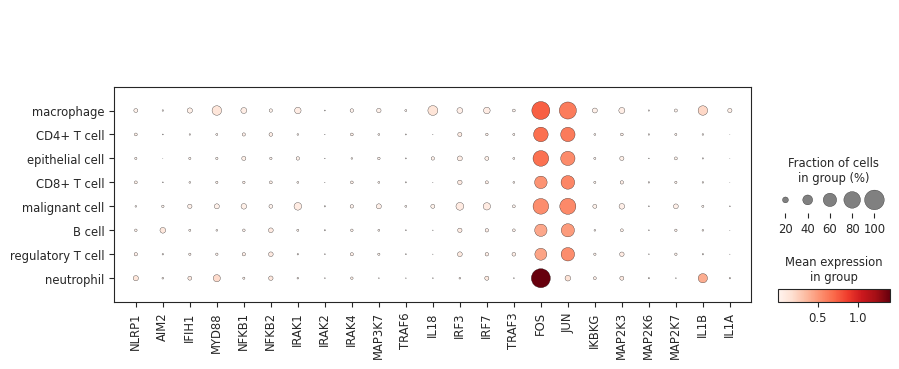

In [240]:
sc.pl.dotplot(paired_adata, gene_list, groupby='cell_type', dendrogram=False, log=True, use_raw=False)

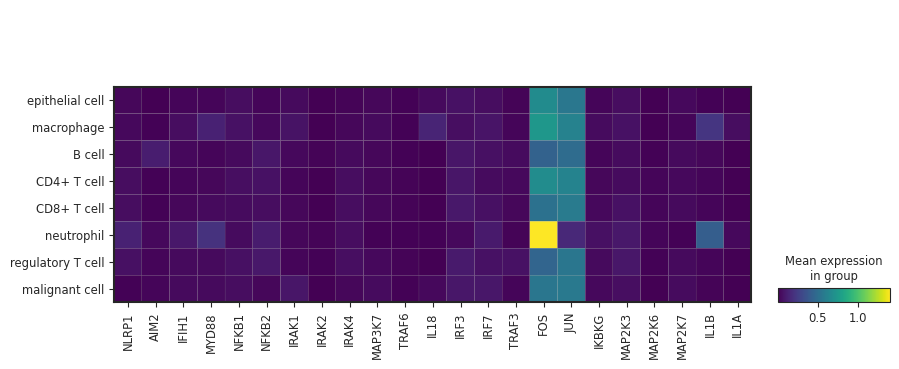

In [219]:
sc.pl.matrixplot(paired_adata, gene_list, groupby='cell_type', dendrogram=False, log=True, use_raw=False)

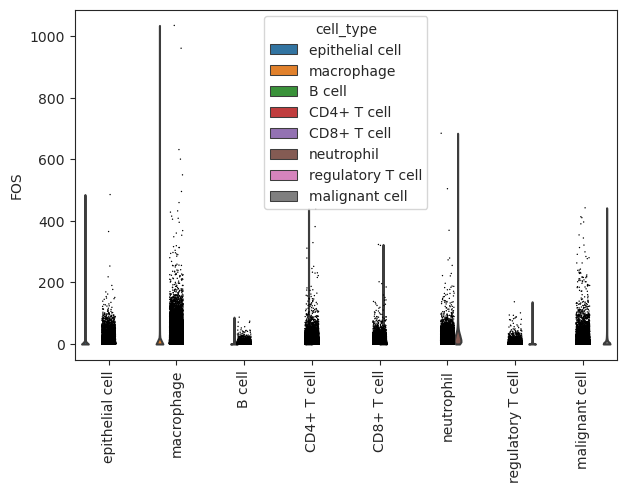

In [230]:
sc.pl.violin(paired_adata, keys='FOS', groupby='cell_type', rotation=90, log=False, use_raw=False, layer= "counts_length_scaled", le)

In [229]:
paired_adata

AnnData object with n_obs × n_vars = 344581 × 17811
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'is_highly_variable', 'mito', 'n_cells_by_counts',